gaussian
periodic
gaussianPeriodic


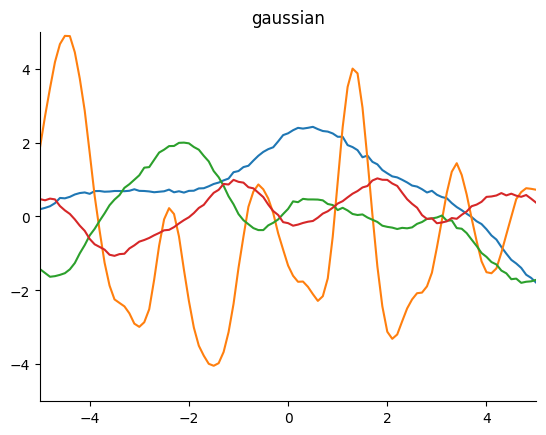

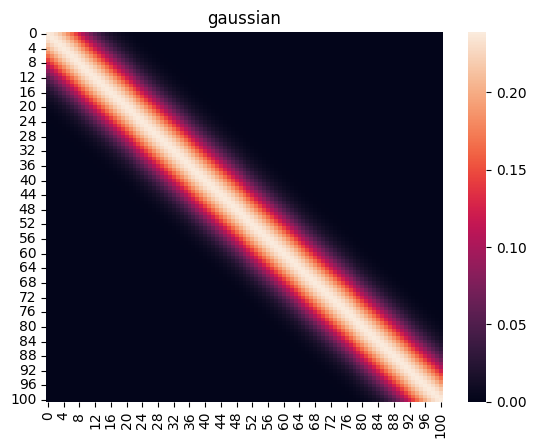

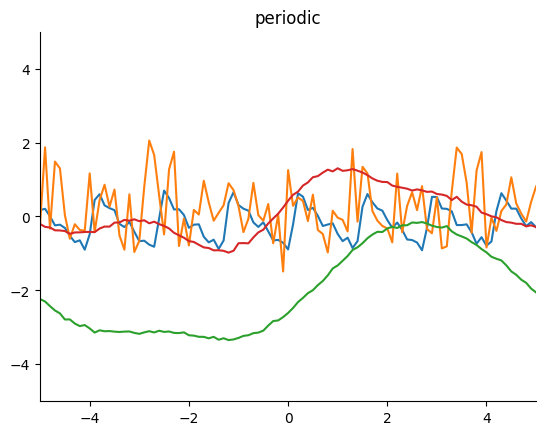

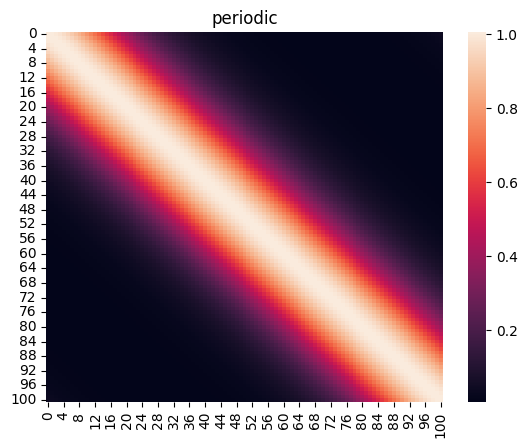

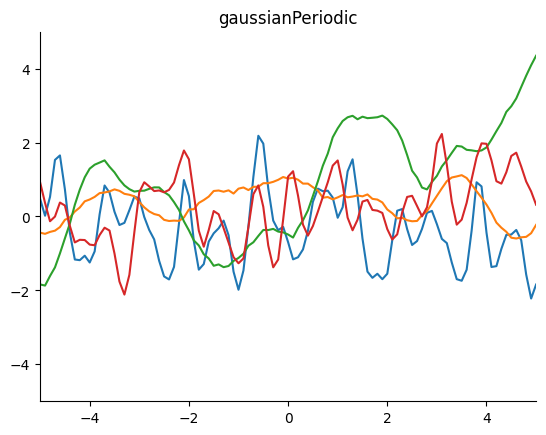

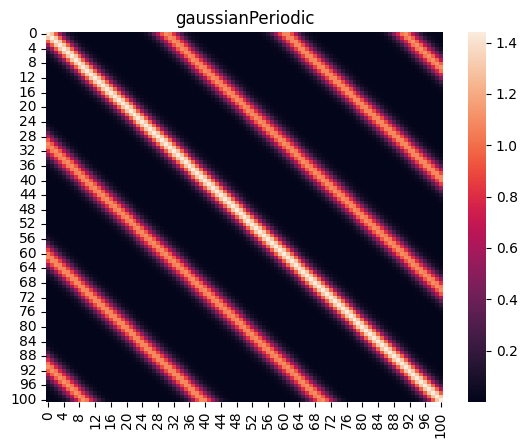

In [15]:
import library.putil as putil
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

xmax = 5
xmin = -5
ymax = 5
ymin = -5
M    = 4
N    = 101
noizeBeta = 0.2

SAVE_FILE = ""

class MyGaussianProcess(torch.nn.Module):
    def __init__(self, kernelName):
        super().__init__()

        # H0 = 1
        self.gaussSigma = nn.Parameter(torch.randn(1))
        self.gaussL = nn.Parameter(torch.randn(1))

        self.periodicSigma = nn.Parameter(torch.randn(1))
        self.periodicL = nn.Parameter(torch.randn(1))
        self.periodicT = nn.Parameter(torch.randn(1) * 5)

        if kernelName == 'gaussian':
            self.kernel = self.kgauss()
        elif kernelName == 'periodic':
            self.kernel = self.kperiodic()
        elif kernelName == 'gaussianPeriodic':
            self.kernel = self.kgaussPlusKperiodic()
        else:
            self.kernel = None
            print("Error : " + kernelName)

    def kgauss (self):
        # (7.10)
        return lambda x, y: (self.gaussSigma**2) * torch.exp (-(x - y)**2 / (2 * (self.gaussL**2)))

    def kperiodic (self):
        # (7.15)
        return lambda x,y: (self.periodicSigma**2) * torch.exp (- (2 / self.periodicL**2) * (torch.sin(torch.pi / torch.abs(self.periodicT) * (x - y)))**2)

    def kgaussPlusKperiodic (self):
        kgaussFunc = self.kgauss()
        kperiodicFunc = self.kperiodic()

        # (7.16)
        return lambda x,y: kgaussFunc(x, y) + kperiodicFunc(x, y)

    def kernel_matrix (self, xx):
        N = len(xx)
        eta = 1e-3

        # Return K
        # small offset for stability
        return torch.tensor (
            [self.kernel (xi, xj) for xi in xx for xj in xx]
        ).reshape(N,N) + eta * torch.eye(N)

    def fgp (self, xx):
        N = len(xx)
        K = self.kernel_matrix (xx)
        return torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(N), K).sample()

    def fgpGetK(self, xx):
        K = self.kernel_matrix (xx)

        return K

    def negativeLogLikelihood(self):
        def negativeLogLikelihoodSub(xx, ys):
            sampleSize = len(ys)
            tensorKXX = self.fgpGetK(xx) + noizeBeta**2 * torch.eye(sampleSize)
            return 0.5 * (torch.dot(torch.mv(torch.linalg.inv(tensorKXX), ys), ys) + torch.log(torch.linalg.det(tensorKXX)) + sampleSize * torch.log(torch.tensor([2*torch.pi])))
        return negativeLogLikelihoodSub

    def updateParam(self, parameters):

        self.gaussSigma.data = nn.Parameter(next(parameters))
        self.gaussL = nn.Parameter(next(parameters))

        self.periodicSigma = nn.Parameter(next(parameters))
        self.periodicL = nn.Parameter(next(parameters))
        self.periodicT = nn.Parameter(next(parameters))

    def forward(self, x):
        return 1

@torch.no_grad()
def plotKernel(kernelName):
    xx = torch.linspace (xmin, xmax, N)

    fig = plt.figure()
    ax = fig.add_subplot()

    print(kernelName)
    for m in range(M):
        model = MyGaussianProcess(kernelName)
    
        yy = model.fgp (xx)
        plt.plot (xx, yy)

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(kernelName)

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(model.fgpGetK (xx))
    ax.set_title(kernelName)

def main ():
    kernelName = ['gaussian', 'periodic', 'gaussianPeriodic']

    for kName in kernelName:
        plotKernel(kName)

    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

1.4329122304916382
0.6852946281433105
0.5434777736663818
-0.2764774560928345
-1.8728166818618774


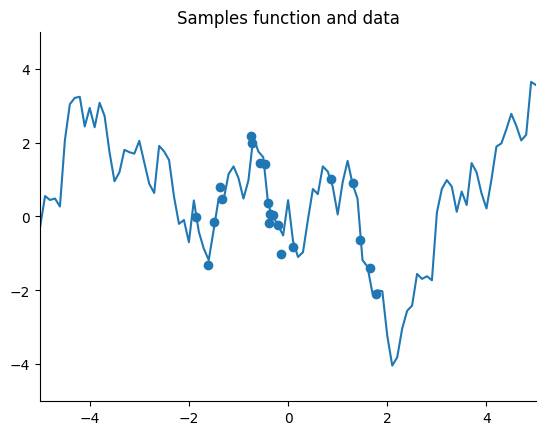

In [16]:
# Sample data points here
# We use eriodic kernel for sampling 

SAMPLE_NUM = 21
SAMPLE_XMIN = -2.0
SAMPLE_XMAX = 2.0

# xs for plot
xx = torch.linspace(xmin, xmax, N)

# Select xs for samples
sampleXs = torch.rand(SAMPLE_NUM) * (SAMPLE_XMAX - SAMPLE_XMIN) + SAMPLE_XMIN

xsAll = torch.concat([xx, sampleXs])
model = MyGaussianProcess('gaussianPeriodic')
kAll = model.fgpGetK(xsAll)

# Sample data
ysAll = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(len(xsAll)), kAll).sample()
yy = ysAll[0 : len(xx)]
#sampleYs = ysAll[len(xx) : ]
sampleYs = ysAll[len(xx) : ] + noizeBeta * torch.randn(SAMPLE_NUM)

# Plot data
fig = plt.figure()
ax = fig.add_subplot()

plt.plot (xx, yy)
plt.scatter(sampleXs, sampleYs)

putil.simpleaxis ()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Samples function and data")

for param in model.parameters():
    print(param.item())

sampledParam = model.parameters()

params : 
1.4329122304916382
0.6852946281433105
0.5434777736663818
-0.2764774560928345
-1.8728166818618774
params : 
1.4329122304916382
0.6852946281433105
0.5434777736663818
-0.2764774560928345
-1.8728166818618774
params : 
1.4329122304916382
0.6852946281433105
0.5434777736663818
-0.2764774560928345
-1.8728166818618774


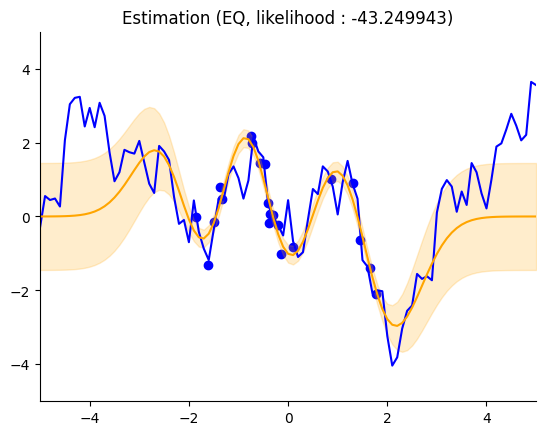

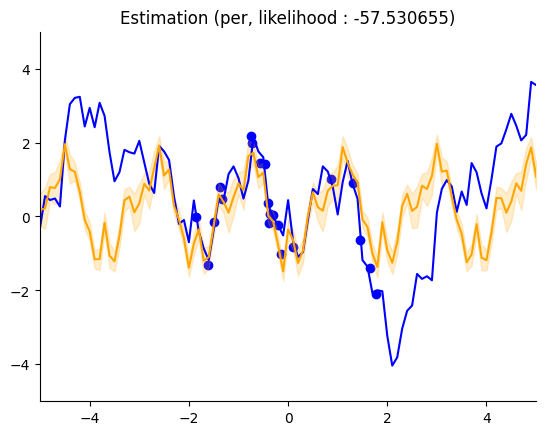

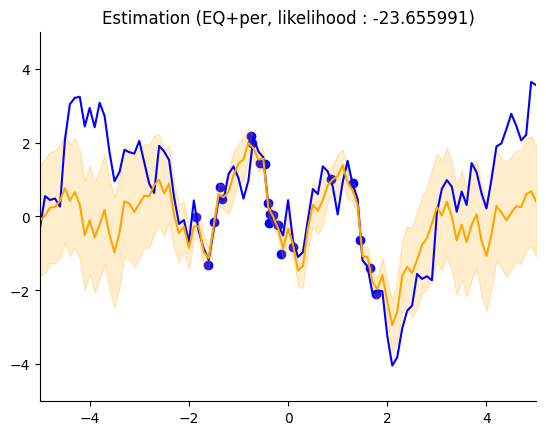

In [17]:
# Estimate the function using periodic kernel
import numpy as np
import itertools

kernels = ['gaussian', 'periodic', 'gaussianPeriodic']
kernelNames = ["EQ", "per", "EQ+per"]

sampleSize = len(sampleXs)
sampledParam1 = sampledParam

for kernel, kernelName in zip(kernels, kernelNames):
    musPer = []
    sigmasPer = []

    sampledParam1, sampledParam2 = itertools.tee(sampledParam1)
    model = MyGaussianProcess(kernel)
    model.updateParam(sampledParam2)

    for x in xx:
        xsEst = torch.concat((sampleXs, torch.tensor([x])))
        kEst = model.fgpGetK(xsEst)
        kXX = kEst[0:sampleSize, 0:sampleSize] + noizeBeta**2 * torch.eye(sampleSize)
        kXXInv = torch.linalg.inv(kXX)
        kXestX = kEst[sampleSize, 0:sampleSize]

        # (7.9)
        # kXXInv is symmetry
        musPer.append(torch.dot(torch.mv(kXXInv, kXestX), sampleYs).item())
        sigmasPer.append(torch.sqrt(kEst[sampleSize, sampleSize] + noizeBeta**2 - torch.dot(torch.mv(kXXInv, kXestX), kXestX)).item())

#    print(musPer)
#    print(sigmasPer)

    # Calculate likelihood
    # (7.17)
    nll = model.negativeLogLikelihood()
    
    logLikelihood = -nll(sampleXs, sampleYs).item()
    
    musUpper = np.array(musPer) + np.array(sigmasPer)
    musBottom = np.array(musPer) - np.array(sigmasPer)

    # Plot data
    fig = plt.figure()
    ax = fig.add_subplot()

    plt.plot(xx, yy, color = "blue")
    plt.plot(xx, musPer, color = "orange")
    plt.scatter(sampleXs, sampleYs, color = "blue")
    ax.fill_between(xx, musUpper, musBottom, alpha = 0.2, color = "orange")

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title("Estimation (" + kernelName + ", likelihood : %f)" % logLikelihood)

    print("params : ")
    for param in model.parameters():
        print(param.item())
